# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Matemática Para Machine Learning</font>

# <font color='blue'>Projeto Construção de um Algoritmo de Machine Learning do Zero</font>

## Aluno: Antonildo Santos


FIRST-ORDER PRECONDITIONING VIA
HYPERGRADIENT DESCENT


Introdução

Trago um exemplo bem Simples, baseado inclusive no que foi mostrado durante o curso. Trata-se de um Paper de autoria de Ted Moskovitz, Rui Wang, Janice Lan, Sanyam Kapoor, Thomas Miconi, Jason Yosinski, Aditya Rawal da Uber AI.
Link https://arxiv.org/abs/1910.08461.

Segundio os autores, neste artigo é abordado um método denominado de pré-condicionamento de primeira ordem (FOP). A FOP não tenta calcular um pré-condicionador específico, como o Hessian inverso, mas usa descida de hipergradiente de primeira ordem (Maclaurin et al., 2015) para aprender uma transformação adaptável on-line diretamente a partir da função objetivo da tarefa. Este método adiciona um valor computacional mínimo e custo de memória para configurações padrão de treinamento em rede profunda e resulta em melhor convergência velocidade e generalização em comparação com abordagens padrão. A FOP pode ser aplicada de forma flexível a qualquer problema de otimização baseado em gradiente.

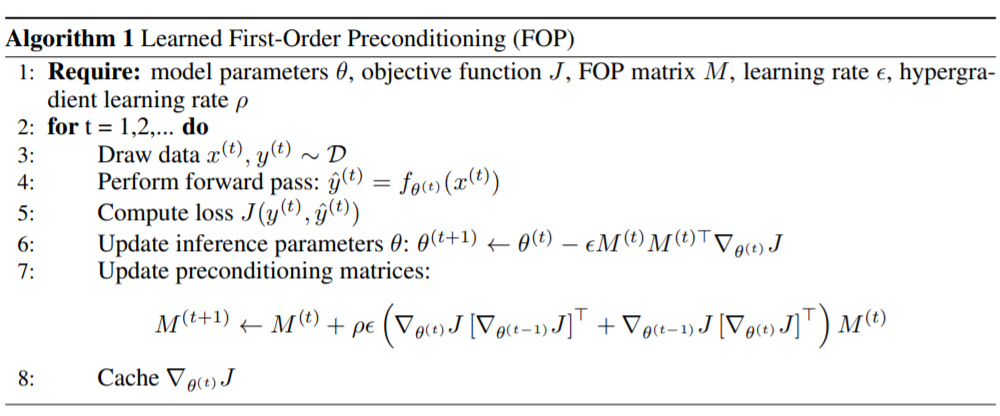

In [1]:
from IPython.display import Image
Image("./FOP Algorithm.png")

Neste projeto utilizarei o conjunto de dados Habitação, que contém informações sobre diferentes casas em Boston, acessado diretamente na biblioteca scikit-learn. Existem 506 amostras e 13 variáveis neste conjunto de dados. O objetivo é prever o valor dos preços da casa usando os recursos fornecidos.

In [2]:
# Importaremos as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [3]:
# Carregando os dados
boston_dataset = load_boston()

In [4]:
# Verificando o conteúdo do Dataset
print(boston_dataset.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [5]:
print(boston_dataset.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [6]:
bd = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
bd.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [7]:
# Criando uma coluna para armazenar a variável Target
bd['valor_alvo'] = boston_dataset.target

In [8]:
# Verificando se existem valores missing
bd.isnull().sum ()

CRIM          0
ZN            0
INDUS         0
CHAS          0
NOX           0
RM            0
AGE           0
DIS           0
RAD           0
TAX           0
PTRATIO       0
B             0
LSTAT         0
valor_alvo    0
dtype: int64

## Análise exploratória de dados

Criando uma matriz de correlação para medir os relacionamentos lineares entre as variáveis. 

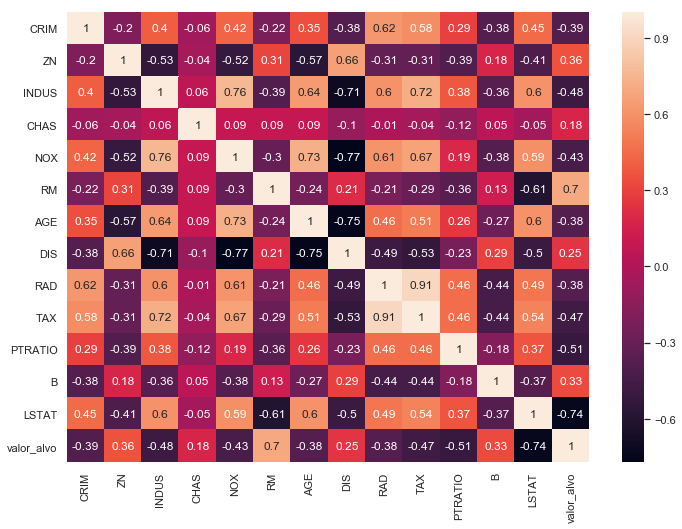

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = bd.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Com base nas observações acima, considerei as variáveis RM e LSTAT como os recursos a serem ultilizados no modelo, pois as mesmas apresentam alta correlação com a variável alvo. Usando um gráfico de dispersão, vamos ver como esses recursos variam em relação ao valor_alvo.

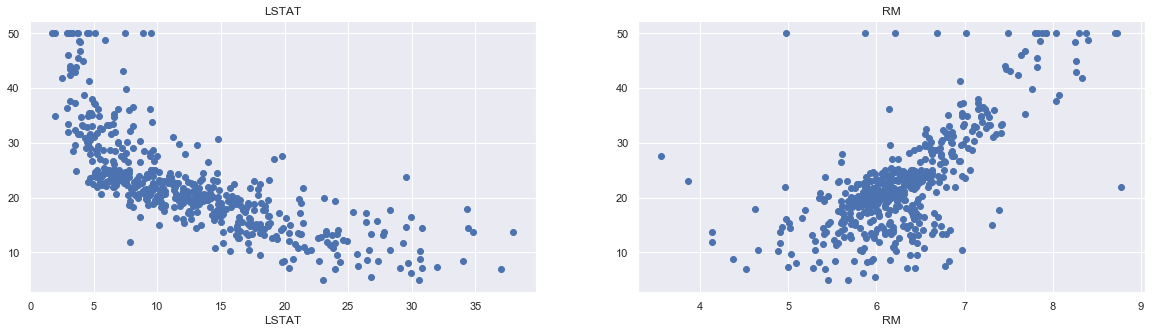

In [10]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = bd['valor_alvo']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = bd[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)

Podemos observar claramente uma correlação negativa para variável LSTAT e uma correlação positiva para a variável RM

In [11]:
#X = np.array(pd.DataFrame(bd['RM'], columns = ['RM']))
X = np.array(pd.DataFrame(np.c_ [bd[ 'LSTAT' ], bd[ 'RM' ]], columns = [ 'LSTAT' , 'RM' ]))
y = np.array(pd.DataFrame(bd['valor_alvo']))

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404, 1)
(102, 1)


In [13]:
# Função de Custo
def  cal_cost(theta, X, y):
    '''
    
    Calcula o custo para X e Y. Objetos que precisamos:
    
    theta = Vetor de thetas
    X     = Vetor de X's np.zeros((2,j))
    y     = Valor atual de y's np.zeros((2,1))
    
    onde:
        j é o número de features
    '''
    
    m = float(len(y))
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions - y))
    return cost

In [14]:
# First-Order Preconditioning via Hypergradient Descent

def FOP(X, y, theta, learning_rate = 0.01, hg_learning_rate=0.001, iterations = 100):
    '''
    X     = Matrix de x com unidades bias
    y     = Vetor de Y
    theta = Vetor de thetas np.random.randn(j,1)
    learning_rate 
    hg_learning_rate = hypergradient learning rate
    iterations = número de iterações
    
    Retorna o vetor theta final e a matriz do histórico de custo sobre o número das iterações
    '''
    # Valores de entrada X e bias
    X_b = np.c_[np.ones((len(X),1)),X]
    m = float(len(y))
    
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,len(X[1])+1))
    alpha = np.random.rand(len(X[1])+1,1)
    M = X_b
    for it in range(iterations):
                
        prediction = np.dot(X_b, theta)
                
        theta = theta - (1/m) * learning_rate * (M.T.dot((prediction - y)))
        M = M + hg_learning_rate * learning_rate * (theta.T +  theta_history[it-1,:].T) * M       
        
        cost_history[it]  = cal_cost(theta, X_b, y)

        theta_history[it,:] = theta.T

       
    return theta, cost_history, theta_history

In [15]:
# Executando Modelo

random.seed( 30 )
# Taxa de aprendiado
lr = 0.001
hg_lr = 0.00003

# Número de iterações de treinamento
n_iter = 1000

# Inicializamos os parâmetros com valores aletórios
theta = np.random.randn(len(X[1])+1,1)

# Treinamento
theta, cost_history, theta_history = FOP(X_train, Y_train, theta, lr, hg_lr, n_iter)


print('Theta0:          {:0.3f}, \nTheta1:          {:0.3f}, \nTheta2:          {:0.3f}'.format(theta[0][0],theta[1][0],theta[2][0]))
print('Custo Final/MSE:  {:0.3f}'.format(cost_history[-1]))

Theta0:          0.820, 
Theta1:          -0.699, 
Theta2:          4.856
Custo Final/MSE:  2595163.560


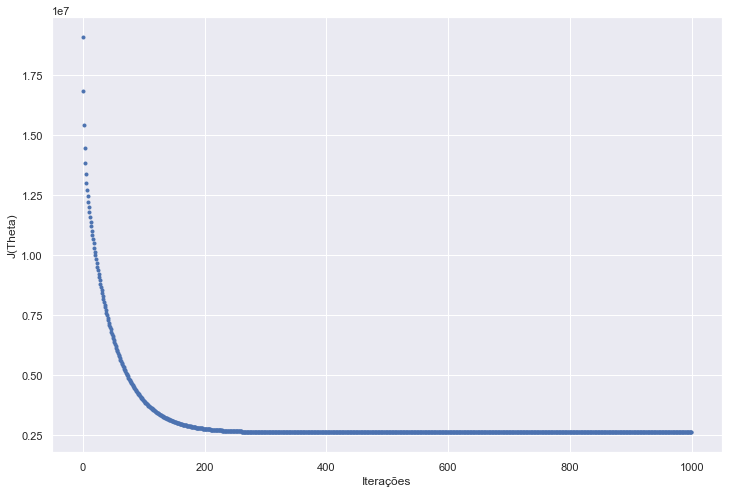

In [16]:
# Gráfico com as iterações e os parâmetros aprendidos no treinamento
fig,ax = plt.subplots(figsize=(12,8))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterações')
_=ax.plot(range(n_iter),cost_history,'b.')

In [17]:
# Gerando as Previsões para os dados de treino
y_train_predict = [theta[0][0]+np.dot(theta[1:].reshape(2),x) for x in X_train]

## Avaliação do modelo
Avaliando o modelo usando RMSE e R2-score.

In [18]:
# Avaliando os dados de treino
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print ( " O desempenho do modelo para o conjunto de treino " )
print ( " ------------------------------------------------ " )
print(' RMSE: {}'.format(rmse))
print(' R2 score: {}'.format(r2))
print("\n")

 O desempenho do modelo para o conjunto de treino 
 ------------------------------------------------ 
 RMSE: 5.639180553838608
 R2 score: 0.629805251587665




In [19]:
# Gerando as Previsões para os dados de teste
y_test_predict = [theta[0][0]+np.dot(theta[1:].reshape(2),x) for x in X_test]

In [20]:
# Avaliando os dados de teste
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print ( " O desempenho do modelo para o conjunto de teste " )
print ( " ----------------------------------------------- " )
print(' RMSE: {}'.format(rmse))
print(' R2 score: {}'.format(r2))
print("\n")

 O desempenho do modelo para o conjunto de teste 
 ----------------------------------------------- 
 RMSE: 5.0945906111902906
 R2 score: 0.6684944309797782




# Conclusão

Para um modelo criado a partir do zero acredito que obteve um desempenho razoável. A pezar de ser um modelo bem simples, pude praticar todo conhecimento adquirido no curso Matemática para Machine Learning. Considero que o maior desafio foi interpretar o paper, na minha opinião tratá-se de uma das tarefa mais difíceis na área de Data Science, espero ter cumprido a missão.